In [1]:
# obtain prism (used for prototyping)
%%bash
rm -r ./*
wget -q https://www.prismmodelchecker.org/dl/prism-4.8-linux64-x86.tar.gz
gunzip prism-4.8-linux64-x86.tar.gz
tar -xf prism-4.8-linux64-x86.tar
cd prism-4.8-linux64-x86
./install.sh
bin/prism
ln -s prism-4.8-linux64-x86/bin/prism ../.

Installing PRISM (directory=/content/prism-4.8-linux64-x86)
Setting path in startup script /content/prism-4.8-linux64-x86/bin/xprism...
Setting path in startup script /content/prism-4.8-linux64-x86/bin/prism...
Installation complete.
PRISM
=====

Version: 4.8
Date: Sat Jan 13 10:35:57 UTC 2024
Hostname: 6204e51f6f1c
Memory limits: cudd=1g, java(heap)=1g
Command line: prism
Usage: prism [options] <model-file> [<properties-file>] [more-options]

For more information, type: prism -help


In [2]:
#install bppy
%%bash
wget -q https://github.com/bThink-BGU/BPpy/archive/master.zip
unzip -q master.zip
pip install BPpy-master/.

Processing ./BPpy-master
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for bppy: filename=bppy-1.0.1-py3-none-any.whl size=31893 sha256=8eb9a301067281d1e2480e6fce71acde1ac395067891a9bc6feb9f306dbb02de
  Stored in directory: /root/.cache/pip/wheels/95/ba/83/7029e27aa75fe66a3305735f4df34180688f429cb7ad1976e5
Successfully built bppy
  Attempting uninstall: bppy
    Found existing installation: bppy 1.0.1
    Uninstalling bppy-1.0.1:
      Successfully uninstalled bppy-1.0.1


In [3]:
import bppy as bp
from bppy.model.sync_statement import *
from bppy.model.b_thread import *
from bppy.analysis.bprogram_converter import BProgramConverter
from bppy.utils.dfs import DFSBProgram
import itertools

In [4]:
class EvaluatorListener(bp.PrintBProgramRunnerListener):
    def starting(self, b_program):
        self.events = []
    def ended(self, b_program):
        pass
    def event_selected(self, b_program, event):
        self.events.append(event.name)
        if len(self.events) == 20:
            raise TimeoutError()

In [5]:
def generate_model(doors_num=3, prizes_num=1, doors_opened_num=1,
                   mode=bp.execution_thread):
    if prizes_num + doors_opened_num >= doors_num:
        return "Invalid parameters"
    doors = [x for x in range(doors_num)]
    all_open = [bp.BEvent(f'open{d}') for d in doors]

    @mode
    def hide_prizes():
        prizes = yield choice({i: 1 / len(doors) for i in doors},
                             repeat=prizes_num, replace=False,sorted=True)
        if prizes_num == 1:
            prizes = (prizes,)
        for hide in prizes:
            yield sync(request=bp.BEvent(f'hide{hide}'))
        yield sync(request=bp.BEvent('done_hiding'))
        dont_open = [bp.BEvent(f'open{d}') for d in prizes]
        yield sync(block=dont_open, waitFor=bp.BEvent('done_host_opening'))
        final_door = yield sync(waitFor=all_open)
        if int(final_door.name[4:]) in prizes:
            yield sync(request=bp.BEvent('win'))
        else:
            yield sync(request=bp.BEvent('lose'))

    @mode
    def make_a_guess():
        yield sync(waitFor=bp.BEvent('done_hiding'))
        guess = 0
        yield sync(request=bp.BEvent(f'guess{guess}'))
        yield sync(block=bp.BEvent(f'open{guess}'))


    @mode
    def open_doors():
        yield sync(waitFor=[ bp.BEvent(f'guess{d}') for d in doors])

        blocked = []
        for _ in range(doors_opened_num):
          e = yield sync(request=[e for e in all_open if e not in blocked])
          blocked += [e]

        yield sync(request=bp.BEvent('done_host_opening'))
        yield sync(request=[e for e in all_open if e not in blocked])


    bp_gen = lambda: bp.BProgram(bthreads=[hide_prizes(), make_a_guess(), open_doors()],
                             event_selection_strategy=bp.SimpleEventSelectionStrategy(),
                             listener=EvaluatorListener())
    event_list = ([bp.BEvent('done_hiding'), bp.BEvent('done_host_opening'), bp.BEvent('guess0')] +
                  [bp.BEvent(e) for e in ['win', 'lose']] +
                  [bp.BEvent(f'{action}{i}') for action, i in itertools.product(['hide', 'open'], doors)])
    return bp_gen, event_list

In [6]:
# sanity check
bp_gen, event_list = generate_model(mode=bp.execution_thread, doors_num=5,
                                    prizes_num=2, doors_opened_num=2)
model = bp_gen()
model.run()
print(model.listener.events)

['hide1', 'hide4', 'done_hiding', 'guess0', 'open3', 'open2', 'done_host_opening', 'open1', 'win']


# Sampling evaluation

In [7]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from time import perf_counter_ns

In [8]:
def sample_comb(dpo=(3,1,1), gen_function=generate_model, max_run=1000):
    d,p,o = dpo
    bp_gen, _ = gen_function(d, p, o, mode=bp.execution_thread)
    hist = []
    hist_mean, mean = [], 0
    times = []
    start_time = perf_counter_ns()
    for n in range(1, max_run):
        model = bp_gen()
        model.run()
        res = model.listener.events
        new_val = int('win' in res)
        hist.append(new_val)
        delta = new_val - mean
        mean += delta / n
        hist_mean.append(mean)
        times.append(perf_counter_ns()-start_time)
    return(np.array(hist_mean), hist, np.array(times)/1000000000)

In [9]:
m, h, t=  sample_comb((4, 2, 1))
m[-1]

0.7597597597597605

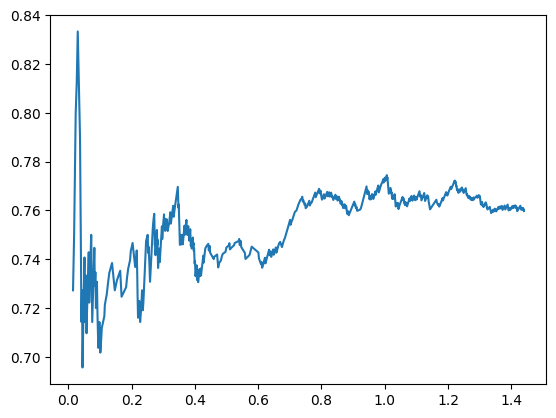

In [10]:
plt.plot(t[10:], m[10:])

# Translation evaluation

In [14]:
d_nums = 4
bp_gen, event_list = generate_model(doors_num=d_nums,
                                    prizes_num=2,
                                    doors_opened_num=1,
                                    mode=bp.analysis_thread)
event_nums = {e.name: i for i, e in enumerate(event_list)}
conv = BProgramConverter(bp_gen, event_list)
output = conv.to_prism('monty.prism')

In [15]:
win = f'(F event=' + str(event_nums['win']) + ')'
with open("prop.csl", 'w+') as f:
  f.write(f"P=? [{win}]")

In [16]:
!./prism -cuddmaxmem 3g -javamaxmem 4g -javastack 500m -dtmc monty.prism  prop.csl

PRISM
=====

Version: 4.8
Date: Sat Jan 13 10:36:59 UTC 2024
Hostname: 6204e51f6f1c
Memory limits: cudd=3g, java(heap)=4g
Command line: prism -cuddmaxmem 3g -javamaxmem 4g -javastack 500m -dtmc monty.prism prop.csl

Parsing model file "monty.prism"...

Type:        DTMC
Modules:     main bt0 bt1 bt2
Variables:   event s_bt0 s_bt1 s_bt2

Parsing properties file "prop.csl"...

1 property:
(1) P=? [ (F event=3) ]

---------------------------------------------------------------------

Model checking: P=? [ (F event=3) ]

Building model...

Computing reachable states...

Reachability (BFS): 10 iterations in 0.00 seconds (average 0.000400, setup 0.00)

Time for model construction: 0.387 seconds.


Type:        DTMC
States:      66 (1 initial)
Transitions: 83

Transition matrix: 878 nodes (4 terminal), 83 minterms, vars: 16r/16c

Prob0: 10 iterations in 0.00 seconds (average 0.000300, setup 0.00)

Prob1: 9 iterations in 0.01 seconds (average 0.001000, setup 0.00)

yes = 31, no = 7, maybe = 28